# User Cold Start: Stories Dataset

Лаботоратория по искусственному интеллекту, Сбербанк. 

Авторы: [Борис Шминке](<mailto:Shminke.B.A@omega.sbrf.ru>), [Роза Айсина](<mailto:Aysina.R.M@omega.sbrf.ru>). 

О чем: модель холодного старта для пользователей. Схема разбиения - делим лог на две рандомные части.

## Содержание

1. [Импорты, создание спарк-сессии](#intro)
2. [Подготовка данных](#data-preparator)
3. [Линейный рекомендатель на основе эмбеддингов](#linear-recommender)
3.1. [Запуск single модели](#linear-recommender-single)
3.2. [Подбор гиперпараметров](#linear-recommender-scenario)
4. [Рекомендатель на основе популярности объектов](#popular-recommender)
4.1. [Запуск single модели](#popular-recommender-single)

### Импорты, создание спарк-сессии <a name='intro'></a>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import os
import re
import sys
from collections import Counter
from datetime import datetime
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as sf
from pyspark.sql.types import DoubleType, StringType, StructType, StructField, TimestampType

from sklearn.feature_extraction.text import CountVectorizer

In [3]:
parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [4]:
parent_dir

'/datascc/aysina-rm/code/sponge-bob-magic'

In [5]:
os.environ['PYTHONPATH']

'/datascc/aysina-rm/pip_packages:/datascc/aysina-rm/pip_packages:'

In [6]:
os.environ['PYTHONPATH'] += "/datascc/aysina-rm/code/sponge-bob-magic" + os.pathsep
os.environ['PYTHONPATH'] += "/datascc/aysina-rm/code/sponge-bob-magic/sponge_bob_magic" + os.pathsep

In [7]:
os.environ['PYTHONPATH']

'/datascc/aysina-rm/pip_packages:/datascc/aysina-rm/pip_packages:/datascc/aysina-rm/code/sponge-bob-magic:/datascc/aysina-rm/code/sponge-bob-magic/sponge_bob_magic:'

In [60]:
from sponge_bob_magic.data_preparator.data_preparator import DataPreparator
from sponge_bob_magic.metrics.metrics import Metrics
from sponge_bob_magic.models.linear_recomennder import LinearRecommender
from sponge_bob_magic.models.popular_recomennder import PopularRecommender
from sponge_bob_magic.scenarios.linear_scenario import LinearScenario
from sponge_bob_magic.validation_schemes import ValidationSchemes

In [9]:
# отображение максимальной ширины колонок в pandas датафреймах
pd.options.display.max_colwidth = -1

In [10]:
spark_memory = "256g"
spark_cores = "40"
user_home = "/datascc/aysina-rm"

spark = (
    SparkSession
    .builder
    .config('spark.driver.memory', spark_memory)
    .config("spark.sql.shuffle.partitions", "64")
    .config('spark.local.dir', os.path.join(user_home, "tmp"))
    .master(f'local[{spark_cores}]')
    .enableHiveSupport()
    .getOrCreate()
)

spark

In [11]:
spark_logger = logging.getLogger('py4j')
spark_logger.setLevel(logging.WARN)

In [12]:
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s, %(name)s, %(levelname)s: %(message)s',
                              datefmt='%d-%b-%y %H:%M:%S')
hdlr = logging.StreamHandler()
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)
logger.setLevel(logging.DEBUG)

## Подготовка данных <a name='data-preparator'></a>

В этой папке находятся данные за сентябрь и один день октября (2019 год):

In [13]:
!ls /datascc/share/small_data

user_item_data2019-09-01.csv  user_item_data2019-09-17.csv
user_item_data2019-09-02.csv  user_item_data2019-09-18.csv
user_item_data2019-09-03.csv  user_item_data2019-09-19.csv
user_item_data2019-09-04.csv  user_item_data2019-09-20.csv
user_item_data2019-09-05.csv  user_item_data2019-09-21.csv
user_item_data2019-09-06.csv  user_item_data2019-09-22.csv
user_item_data2019-09-07.csv  user_item_data2019-09-23.csv
user_item_data2019-09-08.csv  user_item_data2019-09-24.csv
user_item_data2019-09-09.csv  user_item_data2019-09-25.csv
user_item_data2019-09-10.csv  user_item_data2019-09-26.csv
user_item_data2019-09-11.csv  user_item_data2019-09-27.csv
user_item_data2019-09-12.csv  user_item_data2019-09-28.csv
user_item_data2019-09-13.csv  user_item_data2019-09-29.csv
user_item_data2019-09-14.csv  user_item_data2019-09-30.csv
user_item_data2019-09-15.csv  user_item_data2019-10-01.csv
user_item_data2019-09-16.csv


In [14]:
path_log = '/datascc/share/small_data'

In [15]:
dp = DataPreparator(spark)

#### Загрузка лога:

In [16]:
df = dp.transform_log(
    path=path_log,
    format_type="csv",
    columns_names={
        "timestamp": "_c0", 
        "user_id": "_c1", 
        "item_id": "_c2", 
        "relevance": "_c3"
    }
).cache()

In [17]:
df.show(3)

+-------------------+-------+-------+---------+----------+
|          timestamp|user_id|item_id|relevance|   context|
+-------------------+-------+-------+---------+----------+
|2019-09-23 00:00:00|    268|  12552|      0.0|no_context|
|2019-09-23 00:00:00|    268|  12570|      1.0|no_context|
|2019-09-23 00:00:00|    268|  12332|      0.0|no_context|
+-------------------+-------+-------+---------+----------+
only showing top 3 rows



In [18]:
df.count()

48522117

In [19]:
df.agg(*(sf.countDistinct(sf.col(c)).alias(c) for c in df.columns)).show()

+---------+-------+-------+---------+-------+
|timestamp|user_id|item_id|relevance|context|
+---------+-------+-------+---------+-------+
|       31|4877611|    658|        2|      1|
+---------+-------+-------+---------+-------+



In [20]:
df.agg(sf.min(sf.col("timestamp")), sf.max(sf.col("timestamp"))).show()

+-------------------+-------------------+
|     min(timestamp)|     max(timestamp)|
+-------------------+-------------------+
|2019-09-01 00:00:00|2019-10-01 00:00:00|
+-------------------+-------------------+



In [21]:
df_short = df.limit(1000).cache()

#### Загрузка фичей (эмбеддингов юзеров и айтемов):

Названия полей соответствуют выгрузке, которую делал Иван Киреев:

In [22]:
user_feature_cols = ["v" + ("000" + str(i))[-3:] for i in range(256)]

user_features = dp.transform_features(
    "/datascc/share/parquet_embeddings/",
    format_type="parquet",
    columns_names={
        "timestamp": "application_date", 
        "user_id": "client_dk", 
        "features": user_feature_cols
    }
)

Фичи айтемов можно сгенерировать кодом из тетрадки:

https://stash.ca.sbrf.ru/projects/AI-LAB/repos/stories_recsys/browse/experiments/prepare_text_embeddings.ipynb


In [23]:
item_feature_cols = ["t" + str(i) for i in range(256)]

item_features = dp.transform_features(
    "/datascc/share/stories_texts_embeddings",
    format_type="parquet",
    columns_names={
        "item_id": "campaign_id", 
        "features": item_feature_cols
    }
)

### Делим выборку на трейн и тест <a name='splitter'></a>

In [24]:
splitter = ValidationSchemes(spark)

train, test_input, test = splitter.log_split_by_date(
    df,
    test_start="2019-10-01",
    drop_cold_items=False,
    drop_cold_users=False
)

test_positive = test.filter("relevance == 1").cache()

(
    train.count(), 
    test_input.count(), 
    test.count()
)

(46633922, 46633922, 1888195)

In [25]:
(
    train.agg(sf.max("timestamp")).head()[0],
    test.agg(sf.min("timestamp")).head()[0]
)

(datetime.datetime(2019, 9, 30, 0, 0), datetime.datetime(2019, 10, 1, 0, 0))

## Линейный рекомендатель на основе эмбеддингов <a name='linear-recommender'></a>

### Запуск single модели <a name='linear-recommender-single'></a>

In [26]:
lr = LinearRecommender(spark, lambda_param=0.0,
                       elastic_net_param=0.0,
                       num_iter=100)

In [27]:
%%time

lr.fit(
    log=train,
    user_features=user_features,
    item_features=item_features,
    path="/datascc/aysina-rm/code/sponge-bob-magic/data"
)

13-Nov-19 14:37:22, root, DEBUG: Проверка датафреймов
13-Nov-19 14:40:51, root, DEBUG: Предварительная стадия обучения (pre-fit)
13-Nov-19 14:40:52, root, DEBUG: Основная стадия обучения (fit)


CPU times: user 608 ms, sys: 140 ms, total: 748 ms
Wall time: 24min 20s


In [35]:
%%time

recs = lr.predict(
    user_features=user_features,
    item_features=item_features,
    k=10,
    context=None,
    users=test.select("user_id").distinct().cache(),
    items=test.select("item_id").distinct().cache(),
    log=train,
    to_filter_seen_items=True,
    path="/datascc/aysina-rm/code/sponge-bob-magic/data"
).cache()

13-Nov-19 15:11:16, root, DEBUG: Проверка датафреймов


CPU times: user 448 ms, sys: 84 ms, total: 532 ms
Wall time: 9min 56s


In [37]:
recs.count()

1451020

In [38]:
%%time

metric = Metrics.hit_rate_at_k(recs, test_positive, k=10)
metric

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 3.3 s


0.05112955024741216

### Подбор гиперпараметров в линейной модели <a name='linear-recommender-scenario'></a>

In [39]:
linear_scenario = LinearScenario(spark)
linear_scenario.seed = 9876

results = None

In [50]:
%%time

linear_params_grid = {
    'lambda_param': (1e-5, 100), 
    'elastic_net_param': (1e-5, 1)
}

best_params = linear_scenario.research(
    linear_params_grid,
    df,
    users=None, items=None,
    user_features=user_features,
    item_features=item_features,
    test_start="2019-10-01",
    test_size=0.3,
    k=3, context='no_context',
    to_filter_seen_items=True,
    n_trials=1, 
    n_jobs=1,
    how_to_split='by_date'
)

best_params

13-Nov-19 15:46:51, root, DEBUG: Деление на трейн и тест
13-Nov-19 15:46:59, root, DEBUG: Длина трейна и теста: (46633922, 1888195)
13-Nov-19 15:47:00, root, DEBUG: Количество юзеров в трейне и тесте: 4702570, 265681
13-Nov-19 15:47:01, root, DEBUG: Количество айтемов в трейне и тесте: 651, 345
13-Nov-19 15:47:01, root, DEBUG: Модель LinearRecommender
13-Nov-19 15:47:01, root, DEBUG: Первый пре-фит модели
13-Nov-19 15:47:02, root, DEBUG: -------------
13-Nov-19 15:47:02, root, DEBUG: Начало оптимизации параметров
13-Nov-19 15:47:02, root, DEBUG: -- Параметры: {'lambda_param': 0.0006124063759867025, 'elastic_net_param': 0.803030210950413, 'num_iter': 100}
13-Nov-19 15:47:02, root, DEBUG: -- Второй фит модели в оптимизации
13-Nov-19 16:11:44, root, DEBUG: -- Предикт модели в оптимизации
13-Nov-19 16:11:44, root, DEBUG: Проверка датафреймов
13-Nov-19 16:22:01, root, DEBUG: -- Длина рекомендаций: 435306
13-Nov-19 16:22:01, root, DEBUG: -- Подсчет метрики в оптимизации
13-Nov-19 17:09:46, r

CPU times: user 1.13 s, sys: 300 ms, total: 1.43 s
Wall time: 1h 22min 56s


{'lambda_param': 0.0006124063759867025, 'elastic_net_param': 0.803030210950413}

In [52]:
results = pd.concat([linear_scenario.study.trials_dataframe(),results], axis=0)

results

number                state     value             datetime_start  \
                                                                     
0  0      TrialState.COMPLETE  0.027973 2019-11-13 15:47:02.044383   

           datetime_complete            params              user_attrs  \
                             elastic_net_param lambda_param  HitRate@k   
0 2019-11-13 17:09:47.725916  0.80303           0.000612     0.027973    

                                  system_attrs  
      MAP@k    nDCG@k precision@k      _number  
0  0.006301  0.010679  0.009324    0

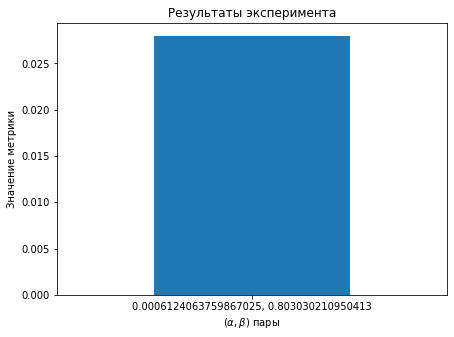

In [55]:
def plot_result_value(results):
    results['value_name'] = (results['params']['lambda_param'].astype(str)
                         .str.cat(results['params']['elastic_net_param'].astype(str), sep=', '))
    
    plt.figure(figsize=(7, 5))
    ax = results['value'].plot(kind='bar', xticks=range(len(results)), rot=0)
    ax.set_xticklabels(results['value_name'].values)

    plt.xlabel(r'$(\alpha, \beta)$' + ' пары')
    plt.ylabel('Значение метрики')
    plt.title('Результаты эксперимента')

    plt.show()
    

plot_result_value(results)

In [56]:
%%time

best_recs = linear_scenario.production(
    best_params,
    df,
    users=None,
    items=None,
    user_features=user_features,
    item_features=item_features,
    k=10,
    context='no_context',
    to_filter_seen_items=True
).cache()

13-Nov-19 17:12:41, root, DEBUG: Проверка датафреймов
13-Nov-19 17:13:41, root, DEBUG: Предварительная стадия обучения (pre-fit)
13-Nov-19 17:13:41, root, DEBUG: Основная стадия обучения (fit)
13-Nov-19 17:36:01, root, DEBUG: Проверка датафреймов
13-Nov-19 17:37:27, root, DEBUG: Выделение дефолтных юзеров
13-Nov-19 17:37:27, root, DEBUG: Выделение дефолтных айтемов


CPU times: user 1.04 s, sys: 136 ms, total: 1.17 s
Wall time: 24min 47s


## Рекомендатель на основе популярности объектов (бейзлайн) <a name='popular-recommender'></a>

### Запуск single модели <a name='popular-recommender-single'></a>

In [61]:
pr = PopularRecommender(spark, alpha=0, beta=0)

In [66]:
%%time

pr.fit(
    log=train.filter("relevance == 1"),
    user_features=None,
    item_features=None,
    path=None
)

13-Nov-19 17:54:03, root, DEBUG: Проверка датафреймов
13-Nov-19 17:54:04, root, DEBUG: Предварительная стадия обучения (pre-fit)
13-Nov-19 17:54:05, root, DEBUG: Среднее количество items у каждого user: 3.0
13-Nov-19 17:54:05, root, DEBUG: Основная стадия обучения (fit)


CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 2.15 s


In [67]:
%%time

recs = pr.predict(
    k=10,
    users=test.select('user_id').distinct(),
    items=test.select('item_id').distinct(),
    context='no_context',
    log=train,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path=None
).cache()

13-Nov-19 17:54:05, root, DEBUG: Проверка датафреймов
13-Nov-19 17:54:07, root, DEBUG: Количество items после фильтрации: 13


CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 1.66 s


In [68]:
recs.show(5)

+-------+---------+----------+--------------------+
|item_id|  user_id|   context|           relevance|
+-------+---------+----------+--------------------+
|  12299|100648575|no_context| 0.05722361757103327|
|  12542|100648575|no_context|0.048543625421663385|
|  12394|100648575|no_context|0.039158814770862686|
|  12510|100648575|no_context| 0.03628671945759774|
|  12386|100648575|no_context| 0.03338298198725909|
+-------+---------+----------+--------------------+
only showing top 5 rows



In [70]:
%%time

metric = Metrics.hit_rate_at_k(recs, test_positive, k=10)
metric

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.11 s


0.10433188673634923